---
title: "Climate DT Parameter Series Plot- Data Access using DEDL HDA"
subtitle: "This notebook authenticates a user with DestinE services, constructs and submits data requests to the DEDL HDA API for Climate Digital Twin projections, polls for availability, downloads GRIB data for multiple years, and visualizes it using EarthKit."
author: " Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, ECMWF, Authentication, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE_Digital_Twins/DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>

# Climate DT - Parameter Series Plot- Data Access using DEDL HDA

### Contents
- **Objective:** This notebook has the aim to show how to how to use the **HDA (Harmonized Data Access)** API to query and access Climate DT data to plot a parameter series. 
- **Data Sources:** https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/
- **Methods:** The data request is performed using HDA REST API. The variable used in this notebook is the "2 metre temperature", the temperature of air at 2m above the surface of land, sea or in-land waters.
  Below the main steps covered by this tutorial.

    1. [Setup](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Setup): Import the required libraries. 
    2. [Order and Download](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Order-and-Download): How to filter and download climate Dt data.
    3. [Plot](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-EarthKit): How to visualize hourly data on single levels data through Earthkit.

- **Prerequisites:** 
   - To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed
   - To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.
- **Expected Output:**
    - 5 grib file files containing the requested data,
    - 5 maps plot of the monthly mean of the 2 metre temperature at different times.


(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Setup)=
# Setup

Import all the required packages.

In [16]:
import destinelab as deauth
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from datetime import datetime
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
import ipywidgets as w

(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Order-and-Download)=
# Order and Download

## Obtain Authentication Token

To access data we need to be authenticated. 

Below how to request of an authentication token using the destinelab package.

In [17]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  serena.avolio
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [18]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoints
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC).
When accessing DestinE data through the HDA API, it is useful to define a small set of configuration constants upfront. These typically include:

- The STAC API endpoint exposed by HDA
- The collection name

While the collection name can be specified as a constant, it does not need to be known in advance, as available collections can be discovered dynamically using the discovery API. 

For this example we want to access the Future Projection obtained using the IFS-NEMO model of the Climate Change Adaptation Digital Twin data. 
To find the right collection ID to use for querying HDA we can use the free text search offered by the HDA Discovery API searching for, e.g., Climate Change Adaptation Digital Twin, Future Projection and IFS-NEMO: <a href="https://hda-staging.lumi.data.destination-earth.eu/stac/v2/collections?limit=10&q=%22Climate%20Change%20Adaptation%20Digital%20Twin%22,%22Future%20Projection%22,%22%20IFS-NEMO%22">HDA Discovery API

The result of this operation will give us the collection ID and some other useful information like the temporal extent and the available parameters.


In [19]:
HDA_STAC_ENDPOINT="https://hda-staging.lumi.data.destination-earth.eu/stac/v2"
print("STAC endpoint: ", HDA_STAC_ENDPOINT)

STAC endpoint:  https://hda-staging.lumi.data.destination-earth.eu/stac/v2


In [20]:
HDA_DISCOVERY_ENDPOINT = HDA_STAC_ENDPOINT+'/collections'
print("HDA discovery endpoint: ", HDA_DISCOVERY_ENDPOINT)

HDA discovery endpoint:  https://hda-staging.lumi.data.destination-earth.eu/stac/v2/collections


### HDA Discovery

In [21]:
discovery_json=(requests.get(HDA_DISCOVERY_ENDPOINT,params = {"q": '"Climate Change Adaptation Digital Twin","Future Projection","IFS-NEMO"'}).json())

#print("Result from the free text search on the HDA Discovery API : ")
#JSON(discovery_json)

In [53]:
print("The discovery result give us:\nthe collection ID : ", discovery_json["collections"][0].get("id"))
print("\nIts time extension : ", discovery_json["collections"][0].get("extent").get("temporal").get("interval"))
#print("\nThe available parameters: ", discovery_json["collections"][0].get("cube:variables").keys())
print("\nThe available parameters: ")
print("(Type in the text box to narrow the list. When only one item remains, its details will appear)")


keys = sorted(discovery_json["collections"][0]["cube:variables"])
txt = w.Text(description="")
out = w.Output()
def run(_):
    q = txt.value.lower()
    with out:
        out.clear_output(); 
        matches = [k for k in keys if q in k.lower()]
        for k in matches:
            print(k)
            if len(matches)==1:            
                var = discovery_json["collections"][0]["cube:variables"][k]
                print(var["description"], "\n")
                print(json.dumps(var["attrs"], indent=2))
                #print(json.dumps(discovery_json["collections"][0]["cube:variables"][k], indent=2))

                
txt.observe(run, names="value"); display(txt, out); run(None)

#print("\nThe information related to each parameter, e.g. the 2 metre temperature: ")
#JSON(discovery_json["collections"][0].get("cube:variables").get("2_metre_temperature(sfc)"))

The discovery result give us:
the collection ID :  EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1

Its time extension :  [['2020-01-01T00:00:00Z', '2039-12-31T23:59:59Z']]

The available parameters: 
(Type in the text box to narrow the list. When only one item remains, its details will appear)


Text(value='')

Output()

In [67]:
COLLECTION_ID="EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1"

## Order and download data
After selecting the correct collection, we need to set up a filter to request our data of interest. 

We are interested to the '2_metre_temperature', we can retrieve the '2_metre_temperature' parameter details (parameter_ID, leveltype, product_type) using the Discovery API and the text box in the cell above to narrow down the list to our parameter of interest.

We would like to obtain the temperature in a certain month and day each 4 years, considering the time extension of our collection.
With this information, we can:

- use *search* to get the precise body and URL needed for the request
- use *order* to directly request the data

In this example, we proceed directly with placing the data order using the order endpoint. 

Examples on how to use the parameter info to search DT data can be found in the ClimateDT-ParameterPlotter.ipynb or in the ClimateDT-ROISelectionandDataAnalysis.ipynb

In [54]:
datechoice = "20200731"

filter_params = {
        "resolution": "high",      # standard/ high 
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc),
        "param": "167",            # 2m Temperature parameter
        "date":datechoice
    }

In the following cell, we use the collection time extensions—which span *2020 to 2039*—to request data for a specific *month* and *day*.

For the selected date, we fetch the 2‑metre temperature every *four years* across the entire extension period.

To retrieve data, you must first submit an order using the filter parameters defined in the previous cell.
Each order is processed asynchronously; once a product becomes available, it can be downloaded.
The code below iterates through the collection extension years and submits one data request per year.

In [55]:
# Initialize a list to store filenames
filenames = []

# Define start and end years
start_year = 2020
end_year = 2039

#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

# Loop 
for year in range(start_year, end_year+1,4):
    # Create a datetime object 
    obsdate = datetime(year, 7, 31)
    datechoice = obsdate.strftime("%Y%m%d")
    filter_params["date"]=datechoice
    response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()

    ordered_item = response.json()

    product_id = ordered_item["id"]
    storage_tier = ordered_item["properties"].get("storage:tier", "online")
    order_status = ordered_item["properties"].get("order:status", "unknown")
    federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

    print(f"Product ordered: {product_id}")
    print(f"Provider: {federation_backend}")
    print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
    print(f"Order status: {order_status}")      

    self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
    item = {}

    for i in range(0, TIMEOUT, STEP):
        print(f"Polling {i + 1}/{TIMEOUT // STEP}")

        response = requests.get(self_url, headers=auth_headers)
        if response.status_code != 200:
            print(response.content)
        response.raise_for_status()
        item = response.json()

        storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

        if storage_tier == ONLINE_STATUS:
            download_url = item["assets"]["downloadLink"]["href"]
            print("Product is ready to be downloaded.")
            print(f"Asset URL: {download_url}")
            break
        sleep(STEP)
    else:
        order_status = item["properties"].get("order:status", "unknown")
        print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
    response = requests.get(download_url, stream=True, headers=auth_headers)
    response.raise_for_status()

    content_disposition = response.headers.get('Content-Disposition')
    total_size = int(response.headers.get("content-length", 0))
    if content_disposition:
        filename = content_disposition.split('filename=')[1].strip('"')
        filename = unquote(filename)
    else:
        filename = os.path.basename(url)

    # Open a local file in binary write mode and write the content
    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
               
    # Add the filename to the list
    filenames.append(filename)

Product ordered: f338191e-87ef-4ac9-adc5-4ef509f72761
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/f338191e-87ef-4ac9-adc5-4ef509f72761/downloadLink
downloading f338191e-87ef-4ac9-adc5-4ef509f72761.grib", attachment; 


26.2MB [00:00, 45.1MB/s]


Product ordered: 0dd4c3df-e7a6-4c18-9a3a-b7dc119632bd
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/0dd4c3df-e7a6-4c18-9a3a-b7dc119632bd/downloadLink
downloading 0dd4c3df-e7a6-4c18-9a3a-b7dc119632bd.grib", attachment; 


26.2MB [00:00, 50.2MB/s]


Product ordered: 628a796c-21f2-46f9-841b-c1c5b1fec2ae
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/628a796c-21f2-46f9-841b-c1c5b1fec2ae/downloadLink
downloading 628a796c-21f2-46f9-841b-c1c5b1fec2ae.grib", attachment; 


26.2MB [00:00, 47.5MB/s]


Product ordered: cf6dfce1-f8b2-4b30-8214-96a632ba3f3e
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/cf6dfce1-f8b2-4b30-8214-96a632ba3f3e/downloadLink
downloading cf6dfce1-f8b2-4b30-8214-96a632ba3f3e.grib", attachment; 


26.2MB [00:00, 48.4MB/s]


Product ordered: 3cd00848-b459-4ed2-8a79-f5e938498dd1
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/3cd00848-b459-4ed2-8a79-f5e938498dd1/downloadLink
downloading 3cd00848-b459-4ed2-8a79-f5e938498dd1.grib", attachment; 


26.2MB [00:00, 48.4MB/s]


(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-EarthKit)=
## EarthKit

Using [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html), we can load the requested datasets and visualize them directly, making it easy to inspect the results and explore the data.

In [56]:
import earthkit.data
import earthkit.plots

In [57]:
# Iterate over filenames
data=[]
for filename in filenames:
    data.append( earthkit.data.from_source("file", filename))


In [65]:
STYLE = earthkit.plots.styles.Style(
    colors="Spectral_r",
    levels=range(-20, 45),
    units="celsius",
    # Extend the colorbar at both ends
    extend="both",
)

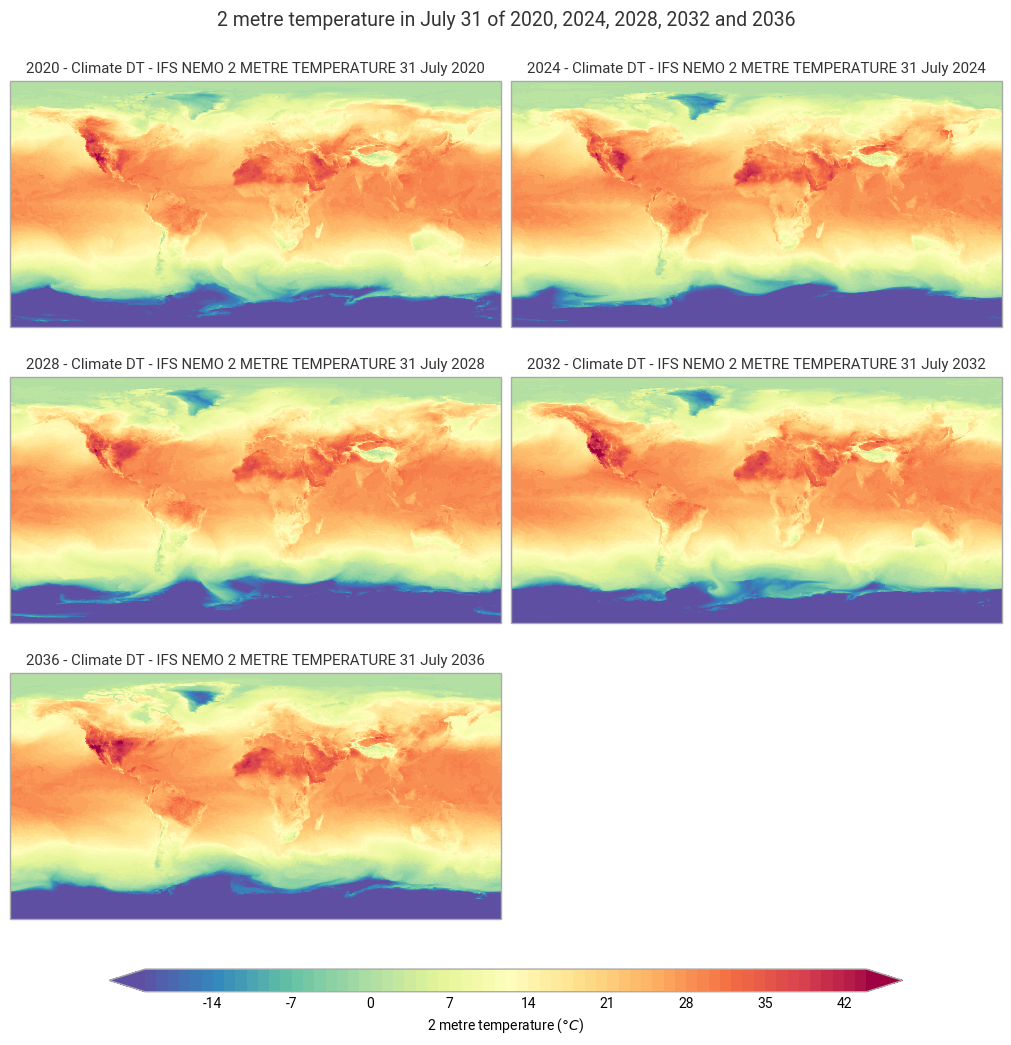

In [66]:
figure = earthkit.plots.Figure(rows=3, columns=2, size=(10, 10))

for i, year in enumerate(range(start_year, end_year+1,4)):
    subplot = figure.add_map()
    subplot.contourf(data[i], style=STYLE)
    subplot.title(f"{year} - Climate DT - IFS NEMO {{short_name!u}} {{time:%d %B %Y}}")


figure.title("{variable_name} in {time:%B %d} of {time:%Y}", fontsize=14)

figure.legend(label="{variable_name!l} ({units})")

figure.show()

## Cleanup

Let's now remove the downloaded files

In [63]:
for filename in filenames:
    os.remove(filename)